# Exploratory behavior during free exploration phase

[Cumulative action selection](#A1)

[Accuracy during free exploration](#A2)

[Task switching during free exploration](#A3)

[Average cumulative task switching](#A4)

[Returns to a task](#A5)

[Evolution of task selection during free exploration in 1D and R](#A6)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import warnings

from ipywidgets import widgets
from IPython.html.widgets import *

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

import io
from IPython.nbformat import current

def execute_notebook(nbfile):
    
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    
    ip = get_ipython()
    
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Preprocessing

Free exploration only

In [2]:
execute_notebook("Preprocessing.ipynb")

['free']
['free', 'train']
['free', 'test', 'train']


In [36]:
# # Define user variables
# users = np.shape(np.unique(csvInt[:,0]))[0]#5
# # For free exploration with Training
# users2 = np.shape(np.unique(csvInt2[:,0]))[0]
# uInf = np.shape(np.unique(informed[:,0]))[0]
# uUni = users2-uInf

# userS = np.shape(np.unique(csvIntS[:,0]))[0]
# print(users, users2, uInf, uUni, userS)

tasks = 4
catLab = ['1D', 'I1D', '2D', 'R']
# For free exploration without Training
usersF = np.shape(np.unique(csvIntF[:,0]))[0]
# For free exploration with Training
usersFT = np.shape(np.unique(csvIntFT[:,0]))[0]
usersFTI = np.shape(np.unique(informed[:,0]))[0]
usersFTU = usersFT-usersFTI
print usersF
# For strategic learning
usersS = np.shape(np.unique(csvIntS[:,0]))[0]
usersSI = np.shape(np.unique(informedSE[:,0]))[0]
usersSU = usersS-usersSI

101


In [ ]:
# Count times correct per task, times task chosen, % for both
metricsUser = []

# id, monster, category, success
for user in range(np.shape(splitCsvSE)[0]):
    questions = splitCsvSE[user]
    # Count number of times a task was selected
    task, ctask = np.unique(questions[:,1], return_counts=True)

    metricsTask = []
    # Count number of times the answer was correct per task and percent
    for t in range(tasks):
        correct = np.sum(questions[questions[:,1] == t,2] == 1) 
        total = np.sum(questions[:,1] == t)
        if t in task:
            # Task category, times task selected, % selection, #times correct on this task, % correct
            metricsTask.append([user, t, ctask[np.where(task==t)][0], ctask[np.where(task==t)][0]/np.shape(questions)[0], correct, np.nan_to_num(correct/total)])
        else:
            metricsTask.append([user, t, 0., 0., correct, np.nan_to_num(correct/total)])

    metricsUser.append(metricsTask)

<a id='A1'></a>
## Cumulative action-selection

Number of occasions a task has been selected at a specific point in time

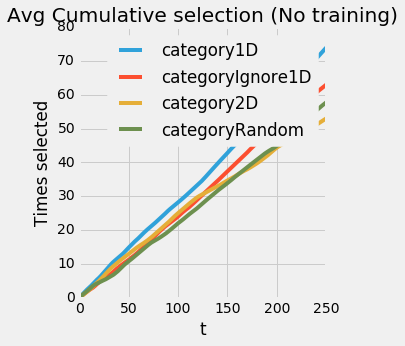

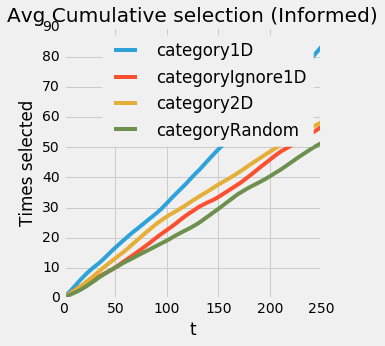

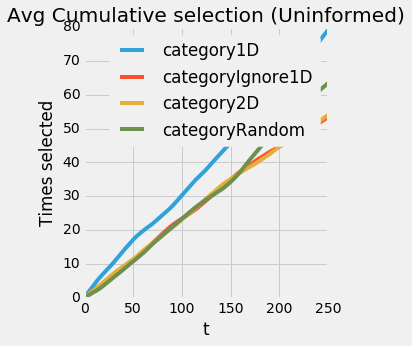

In [4]:
def plotCumSelec(arra, usersArr, title):
    
    # Count at each point in time number of occurrences up to that point and save it into a list
    def countInTime(arr, numOfValues):
        counts = []
        # trials = len(arr)+1
        # print(trials)
        # Only consider the official 250 trials
        trials = 251
        for i in range(trials):
            count = [(arr[:i] == e).sum() for e in range(numOfValues)]
            counts.append(count)
        return np.array(counts).T
    
    # Every element holds a matrix of the evolution of selection
    # Each column corresponds to a t where the max t=250 (it starts at t=0 though)
    # Each column corresponds to the cumulative selection of a task at time t
    cumCounts = []
    for u in range(usersArr):
        # Cumulative count for user u per task
        cumCounts.append( countInTime(arra[u][:,1], tasks) )

    # Dimensions 201x4x251 (201 users, 4 tasks, 251 time steps)
    # Get averages and std dev
    cumCounts = np.asarray(cumCounts)
    avg = np.mean(cumCounts, axis=0)
    std = np.std(cumCounts, axis=0)

    fig, ax = plt.subplots(figsize=(5, 5))

    for t in range(tasks):
        graph = ax.plot(avg[t,:], label=categories[t])

    #     color = graph[0].get_color()
    #     ax.plot(avg[t,:]+std[t,:], color, alpha=0.15)
    #     plt.plot(avg[t,:]-std[t,:], color, alpha=0.15)
    ax.legend()
    ax.set_title(''.join(['Avg Cumulative selection ', title]))
    ax.set_ylabel('Times selected')
    ax.set_xlabel('t')

    plt.tight_layout()
    plt.show()

plotCumSelec(splitCsvF, usersF, '(No training)')

plotCumSelec(splitCsvFTI, usersFTI, '(Informed)')
plotCumSelec(splitCsvFTU, usersFTU, '(Uninformed)')

<a id='A2'></a>
## Accuracy during free exploration

In [5]:
def getCorrect(arr, usersArr):
    corrUser = []
    for u in range(usersArr):
        # Cumulative count for user u per task
        corrTask = []
        for t in range(tasks):
            # Calculate accuracy here since trials are dynamic
            correct = np.sum(arr[u][arr[u][:,1]==t, 2])
            total = np.shape(arr[u][arr[u][:,1]==t, 2])[0]
            #print(correct, total, correct/total)
            #corrTask.append(np.sum(arr[u][arr[u][:,1]==t, 2]))
            corrTask.append(correct/total)
        corrUser.append(corrTask)
    return np.asarray(corrUser)

corr = getCorrect(splitCsvF, usersF)
corr[:,[1, 2]] = corr[:,[2, 1]]

In [6]:
# csvTest only contains the subset of results that were observed during the testing phase
# Split by condition
#csvTest = np.delete(csvTest, 2, axis = 1)
info = csvIntFTECond[csvIntFTECond[:,1]==0]
uninfo = csvIntFTECond[csvIntFTECond[:,1]==1]
# Delete condition column
info = np.delete(info, 1, axis=1)
uninfo = np.delete(uninfo, 1, axis=1)
# Split by users
splitInf = [info[info[:,0]==i] for i in np.unique(info[:,0])]
splitUni = [uninfo[uninfo[:,0]==i] for i in np.unique(uninfo[:,0])]

corrUni = getCorrect(splitUni, usersFTU)
corrInf = getCorrect(splitInf, usersFTI)
corrUni[:,[1, 2]] = corrUni[:,[2, 1]]
corrInf[:,[1, 2]] = corrInf[:,[2, 1]]

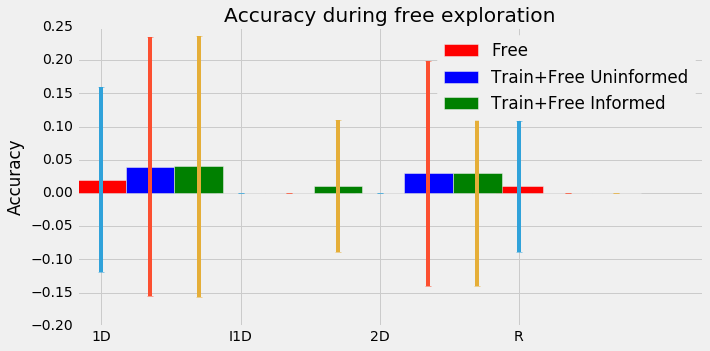

In [7]:
ind = np.arange(tasks)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(ind, np.nanmean(corr,axis=0), width, color='r', yerr=np.nanstd(corr,axis=0))

rects2 = ax.bar(ind+width, np.nanmean(corrUni,axis=0), width, color='b', yerr=np.nanstd(corrUni,axis=0))
rects3 = ax.bar(ind+width*2, np.nanmean(corrInf,axis=0), width, color='g', yerr=np.nanstd(corrInf,axis=0))

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy during free exploration')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1D', 'I1D', '2D', 'R'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Free', 'Train+Free Uninformed', 'Train+Free Informed'))

<a id='A3'></a>
## Task switching

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


IndexError: index 16 is out of bounds for axis 0 with size 16

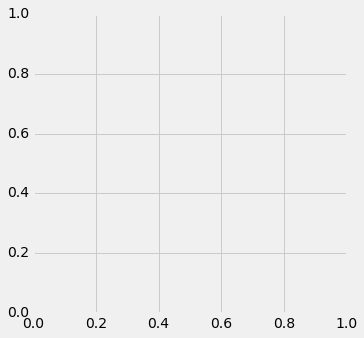

In [74]:
# Count the number of times subjects switched to another task during free exploration
def plotCountSwitchTask(arr, usersArr, title, outliers=False):
    fig, ax = plt.subplots(figsize=(5, 5))
    switchInExperiment = []
    switchInTimeUsers = []
    for u in range(usersArr):
        c = 0
        # Tracks number of task switching at each time step (per user)
        switchInTime = []
        # to homogenize truncate to the standard 250 trials
        for i in range(249): #(len(splitCsv[us][:,1])-1):
            # Check if the task selected now is the same as the task selected one step into the future
            # if that isn't the case then increase the switch counter
            # task has to be column 1
            print u,i
            if arr[u][i,1] != arr[u][i+1,1]:
                c+=1
            switchInTime.append(c)
        # Include or do not include outliers
        if outliers:
            switchInExperiment.append(c)
        elif c < 20:
            switchInExperiment.append(c)
            
        # This holds the evolution of task switching for all users
        switchInTimeUsers.append(switchInTime)
    plt.hist(switchInExperiment, bins=np.arange(np.max(switchInExperiment)+1))
    
    ax.legend()
    ax.set_title(''.join(['Task switching | ', title]))
    ax.set_xlabel('Times switched')
    ax.set_ylabel('Number of people')
    return switchInExperiment, np.asarray(switchInTimeUsers)

def plotEvolutionSwitchTask(arr):
    labels = ['Free Exp', 'Free+Train (All)', 'Free+Train (Informed)', 'Free+Train (Uninformed)']
    fig, ax = plt.subplots(figsize=(5, 5))
    # Go through every instance of the experiment
    for t in range(np.shape(arr)[1]):
        graph = ax.plot(arr[:,t], label=labels[t])
    
    ax.legend()
    ax.set_title('Avg Cumulative Task Switching')
    ax.set_ylabel('Times Switched')
    ax.set_xlabel('t')
    
sw, situF = plotCountSwitchTask(splitCsvF, usersF, 'Free Exp', outliers=False)
sw, situFTI = plotCountSwitchTask(splitCsvFTI, usersFTI, 'Free+Train (Informed)', outliers=False)
sw, situFTU = plotCountSwitchTask(splitCsvFTU, usersFTU, 'Free+Train (Uninformed)',outliers=False)

<a id='A4'></a>
## Average Cumulative Task Switching

In [9]:
# Time a subject has switched tasks in time
evoSwitch = np.column_stack((np.mean(situF,axis=0), np.mean(situFTI,axis=0), np.mean(situFTU,axis=0)))
plotEvolutionSwitchTask(evoSwitch)

NameError: name 'situF' is not defined

<a id='A5'></a>
## Going back to previously selected tasks

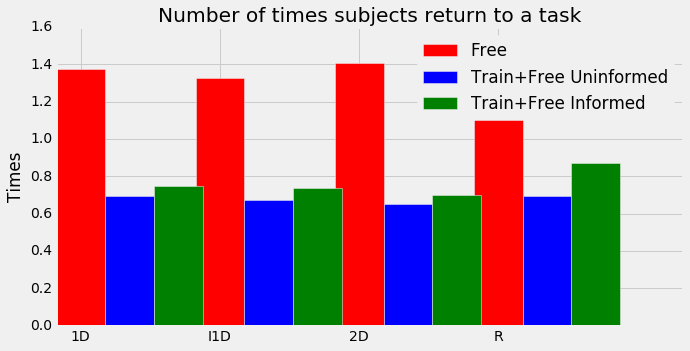

In [10]:
def countReturns(arr, usersArr):
    # Stores returns per task per user
    retUser = []
    for u in range(usersArr):
        # stores return to a task
        retTask = []
        for t in range(tasks):
            # get indices where task shows up
            ind = np.where(arr[u][:,1] == t)[0]
            # get difference between indices
            diff = np.diff(ind)
            # count instances where the difference is not 1 (i.e. they come from another task)
            numOfReturns = np.sum(diff > 1)
            retTask.append(numOfReturns)
        retUser.append(retTask)    
    return retUser


retF = countReturns(splitCsvF, usersF)
retFTI = countReturns(splitCsvFTI, usersFTI)
retFTU = countReturns(splitCsvFTU, usersFTU)


ind = np.arange(tasks)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(ind, np.mean(retF,axis=0), width, color='r')
rects2 = ax.bar(ind+width, np.mean(retFTU,axis=0), width, color='b')
rects3 = ax.bar(ind+width*2, np.mean(retFTI,axis=0), width, color='g')
# add some text for labels, title and axes ticks
ax.set_ylabel('Times')
ax.set_title('Number of times subjects return to a task')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1D', 'I1D', '2D', 'R'))
ax.legend((rects1[0], rects2[0], rects3[0]), ('Free', 'Train+Free Uninformed', 'Train+Free Informed'))

<a id='A6'></a>
## Evolution of task selection during free exploration in 1D and R

In [73]:
# How people are selecting after training
def checkFirstOption(arr, usersArr, taskToCheck):
    selec = []
    for ti in range(250):
        c = 0
        
        for u in range(usersArr):
            
            if arr[u][ti,1] == taskToCheck:
                c+=1
        selec.append(c)
    return np.asarray(selec)
        
def plotEvolutionSel(arr, tas):
    labels = ['Free Exp', 'Free+Train (All)', 'Free+Train (Informed)', 'Free+Train (Uninformed)']
    ta = ['1D', 'I1D', '2D', 'R']
    fig, ax = plt.subplots(figsize=(5, 5))
    # Go through every instance of the experiment
    for t in range(np.shape(arr)[1]):
        graph = ax.plot(arr[:,t], label=labels[t])
    
    ax.legend()
    ax.set_title(''.join(['% People selecting task ', ta[tas]]))
    ax.set_ylabel('%')
    ax.set_xlabel('t')
    #ax.set_ylim([10,45])

for tas in [0,3]:
    print np.shape(splitCsvF)
    #selFTI = checkFirstOption(splitCsvFTI, usersFTI, tas)
    #selFTU = checkFirstOption(splitCsvFTU, usersFTU, tas)
    selF = checkFirstOption(splitCsvF, usersF, tas)
    evoSel = np.column_stack((selF,selFTA))
    plotEvolutionSel(evoSel, tas)

(101,)


IndexError: index 16 is out of bounds for axis 0 with size 16